Importing all libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')

EDA AND DATA CLEANING

In [ ]:
df = pd.read_csv('telco_churn.csv')
print(df.head())
print(f"\nShape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No        

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()
print(f"\nShape after cleaning: {df.shape}")


Shape after cleaning: (7032, 21)


In [ ]:
df = df.drop('customerID', axis=1)

MAPPING AND DISTRIBUTION ANALYSIS

In [ ]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
print(f"\nChurn Distribution:")
print(df['Churn'].value_counts())



Churn Distribution:
Churn
0    5163
1    1869
Name: count, dtype: int64


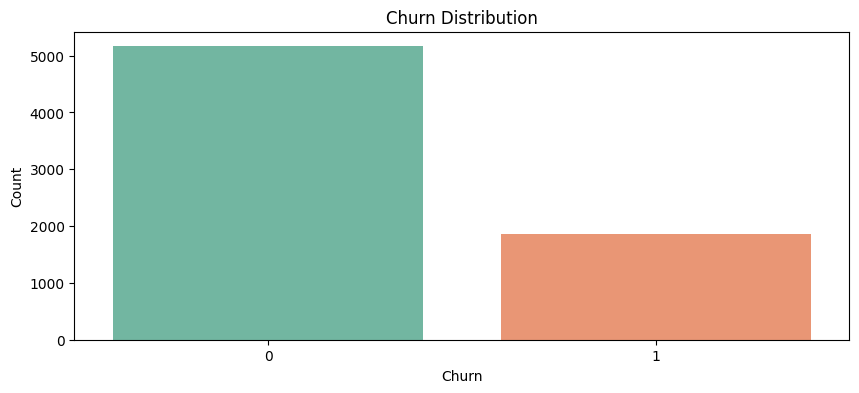

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title('Churn Distribution')
plt.ylabel('Count')
plt.show()


ENCOING CATEGORICAL COLUMNS & DIVIDING DATA

In [ ]:
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

print(f"\nEncoded Data:")
print(df.head())


Encoded Data:
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1  

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']


**CHECKING CORRELATIONS & REMOVING UNWANTED FEATURES**

In [ ]:
numeric_cols = X.select_dtypes(include=[np.number]).columns
correlation_matrix = X[numeric_cols].corr()

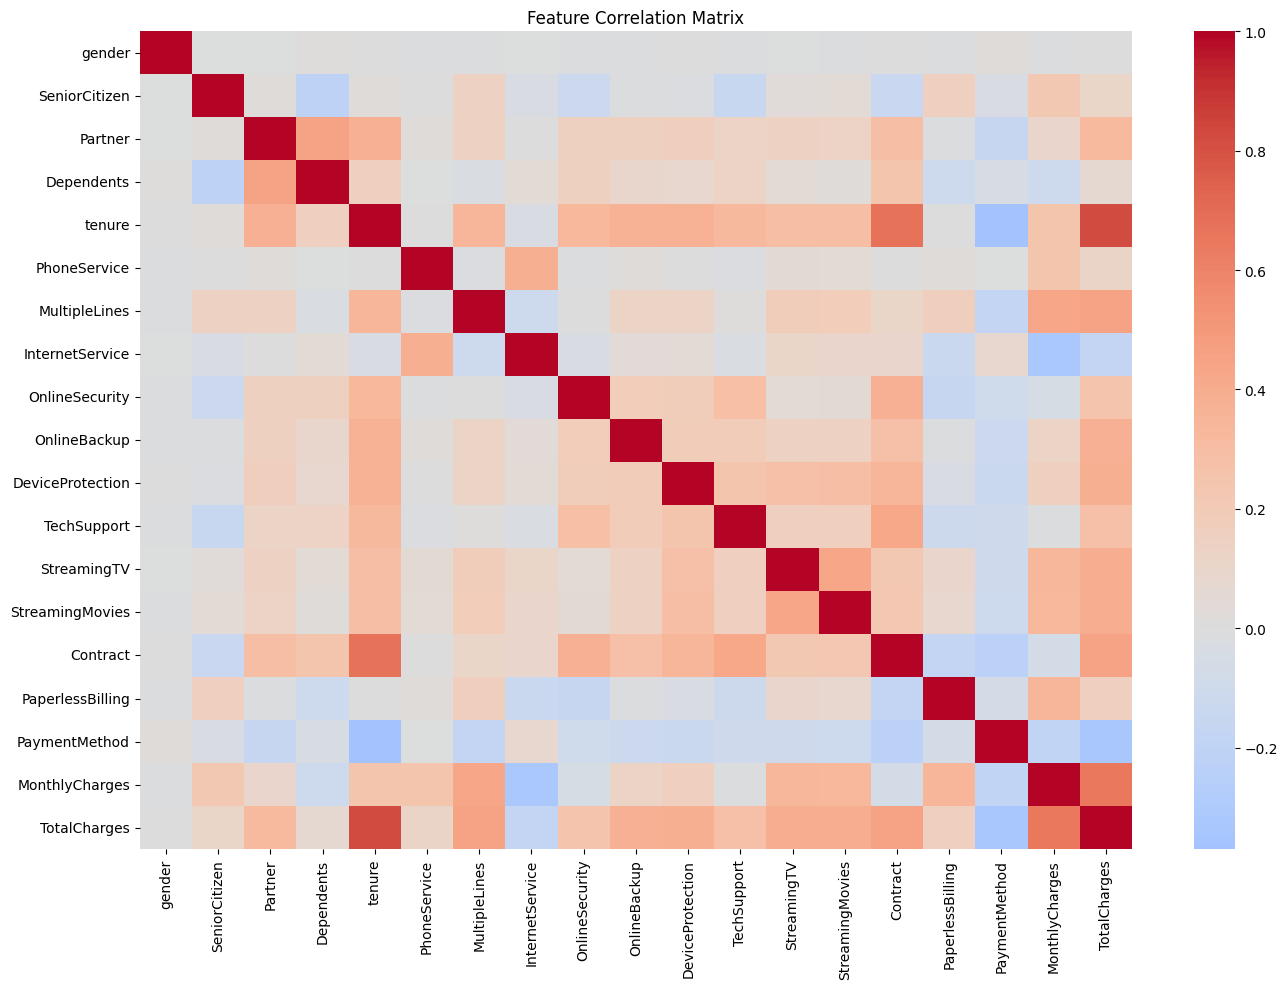

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
churn_correlation = pd.concat([X[numeric_cols], y], axis=1).corr()['Churn'].sort_values(ascending=False)
print(f"\nFeature Correlation with Churn:")
print(churn_correlation)


Feature Correlation with Churn:
Churn               1.000000
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
PaymentMethod       0.107852
MultipleLines       0.038043
PhoneService        0.011691
gender             -0.008545
StreamingTV        -0.036303
StreamingMovies    -0.038802
InternetService    -0.047097
Partner            -0.149982
Dependents         -0.163128
DeviceProtection   -0.177883
OnlineBackup       -0.195290
TotalCharges       -0.199484
TechSupport        -0.282232
OnlineSecurity     -0.289050
tenure             -0.354049
Contract           -0.396150
Name: Churn, dtype: float64


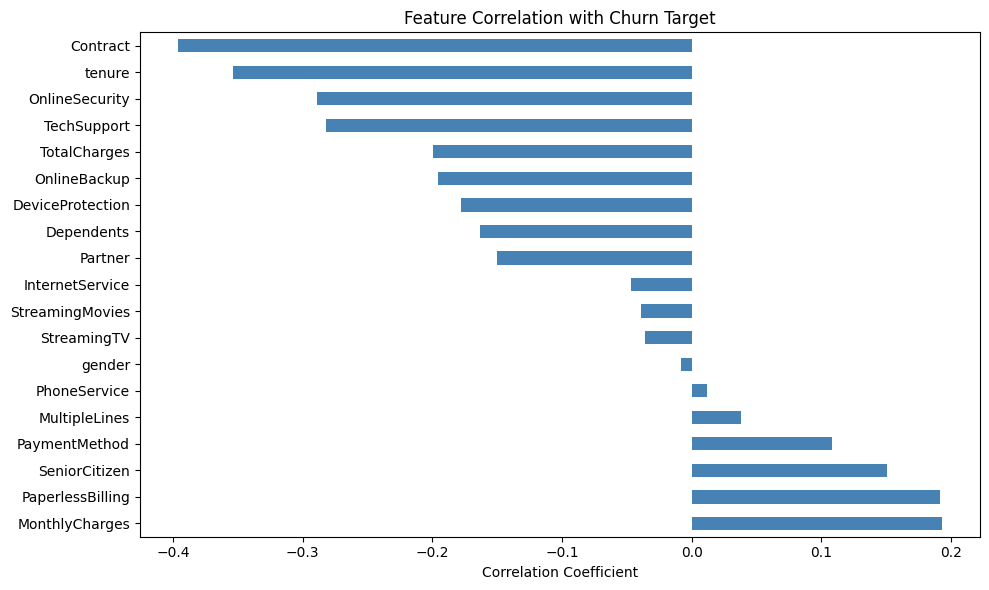

In [ ]:
plt.figure(figsize=(10, 6))
churn_correlation.drop('Churn').plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Churn Target')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


In [ ]:
threshold = 0.01
relevant_features = churn_correlation[abs(churn_correlation) > threshold].index.tolist()
if 'Churn' in relevant_features:
    relevant_features.remove('Churn')
X = X[relevant_features]

In [ ]:
print(f"\nFeatures after correlation filtering: {X.shape[1]}")
print(f"Removed {df.shape[1] - 1 - X.shape[1]} irrelevant features")


Features after correlation filtering: 18
Removed 1 irrelevant features


SCALING AND SPLITTING DATA FOR TRAINING

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"\nX shape: {X_scaled.shape}")
print(f"y shape: {y.shape}")


X shape: (7032, 18)
y shape: (7032,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (5625, 18), Test: (1407, 18)


In [ ]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1))
]

cv_results = []

In [ ]:
for model_name, model in models:
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()

    cv_results.append({
        'Model': model_name,
        'Mean CV Score': mean_score,
        'Std Dev': std_score,
        'Model Object': model
    })

    print(f"\n{model_name}:")
    print(f"  CV Scores: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"  Mean: {mean_score:.4f} | Std: {std_score:.4f}")


Logistic Regression:
  CV Scores: ['0.8343', '0.8721', '0.8441', '0.8189', '0.8576']
  Mean: 0.8454 | Std: 0.0184

Random Forest:
  CV Scores: ['0.8221', '0.8365', '0.8238', '0.7989', '0.8349']
  Mean: 0.8232 | Std: 0.0135

Gradient Boosting:
  CV Scores: ['0.8319', '0.8694', '0.8453', '0.8193', '0.8545']
  Mean: 0.8441 | Std: 0.0174

XGBoost:
  CV Scores: ['0.8085', '0.8389', '0.8230', '0.8010', '0.8342']
  Mean: 0.8211 | Std: 0.0145

LightGBM:
  CV Scores: ['0.8215', '0.8566', '0.8427', '0.8133', '0.8426']
  Mean: 0.8354 | Std: 0.0157


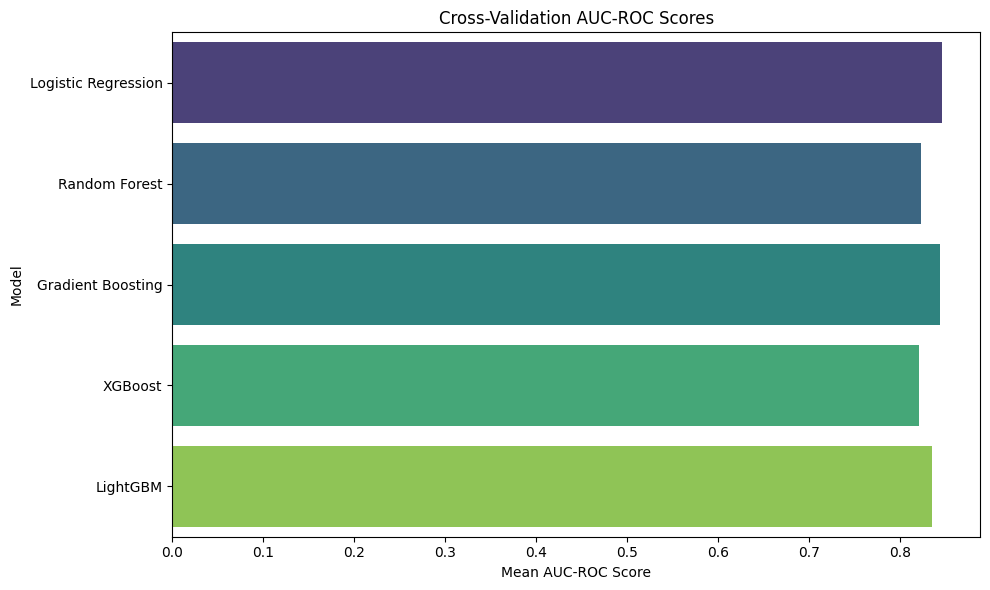

In [ ]:
cv_df = pd.DataFrame({
    'Model': [r['Model'] for r in cv_results],
    'Mean CV Score': [r['Mean CV Score'] for r in cv_results],
    'Std Dev': [r['Std Dev'] for r in cv_results]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=cv_df, x='Mean CV Score', y='Model', palette='viridis')
plt.title('Cross-Validation AUC-ROC Scores')
plt.xlabel('Mean AUC-ROC Score')
plt.tight_layout()
plt.show()

IDENTIFYING THE BEST MODEL AND TRAINING

In [ ]:
best_result = max(cv_results, key=lambda x: x['Mean CV Score'])
best_model_name = best_result['Model']
best_model = best_result['Model Object']
best_cv_score = best_result['Mean CV Score']

print(f"\n BEST MODEL: {best_model_name}")
print(f"CV Score: {best_cv_score:.4f}\n")

best_model.fit(X_train, y_train)


 BEST MODEL: Logistic Regression
CV Score: 0.8454



LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"TEST SET METRICS")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

TEST SET METRICS
Accuracy: 0.7939
Precision: 0.6250
Recall: 0.5615
F1-Score: 0.5915
AUC-ROC: 0.8344



Confusion Matrix:
[[907 126]
 [164 210]]


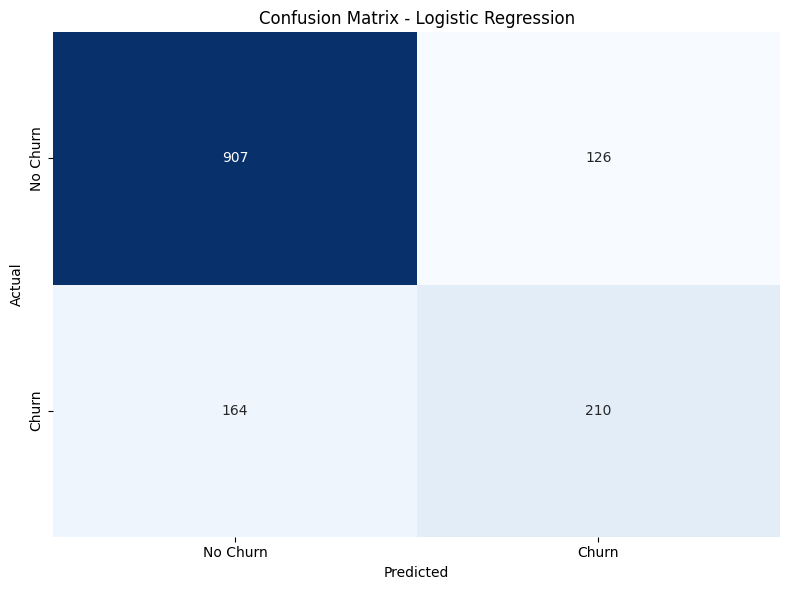

In [ ]:

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.88      0.86      1033
       Churn       0.62      0.56      0.59       374

    accuracy                           0.79      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.79      0.79      1407



DUMPING THE MODEL

In [ ]:

with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
